## Objetivo



 Construir un modelo para predecir el precio medio  de  compra por distrito en California.

## Enmarcando el problema

El cliente nos dice que la salida del modelo alimenta otro sistema de Machine Learning, junto con otras señales. El objetivo del pipeline es determinar en que distritos será rentable invertir.
Actualmente, el precio pro distrito lo estiman expertos manualmente, mediante reglas complejas. Esto les consume grandes recursos y además tienen errores en sus estimaciones de más del 10 %. 
Nos recomienda utilizar el censo de datos de California para crear el modelo.

## SETUP

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

## CARGA DE DATOS

In [4]:
housing = pd.read_csv('DATASET/housing.csv')
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


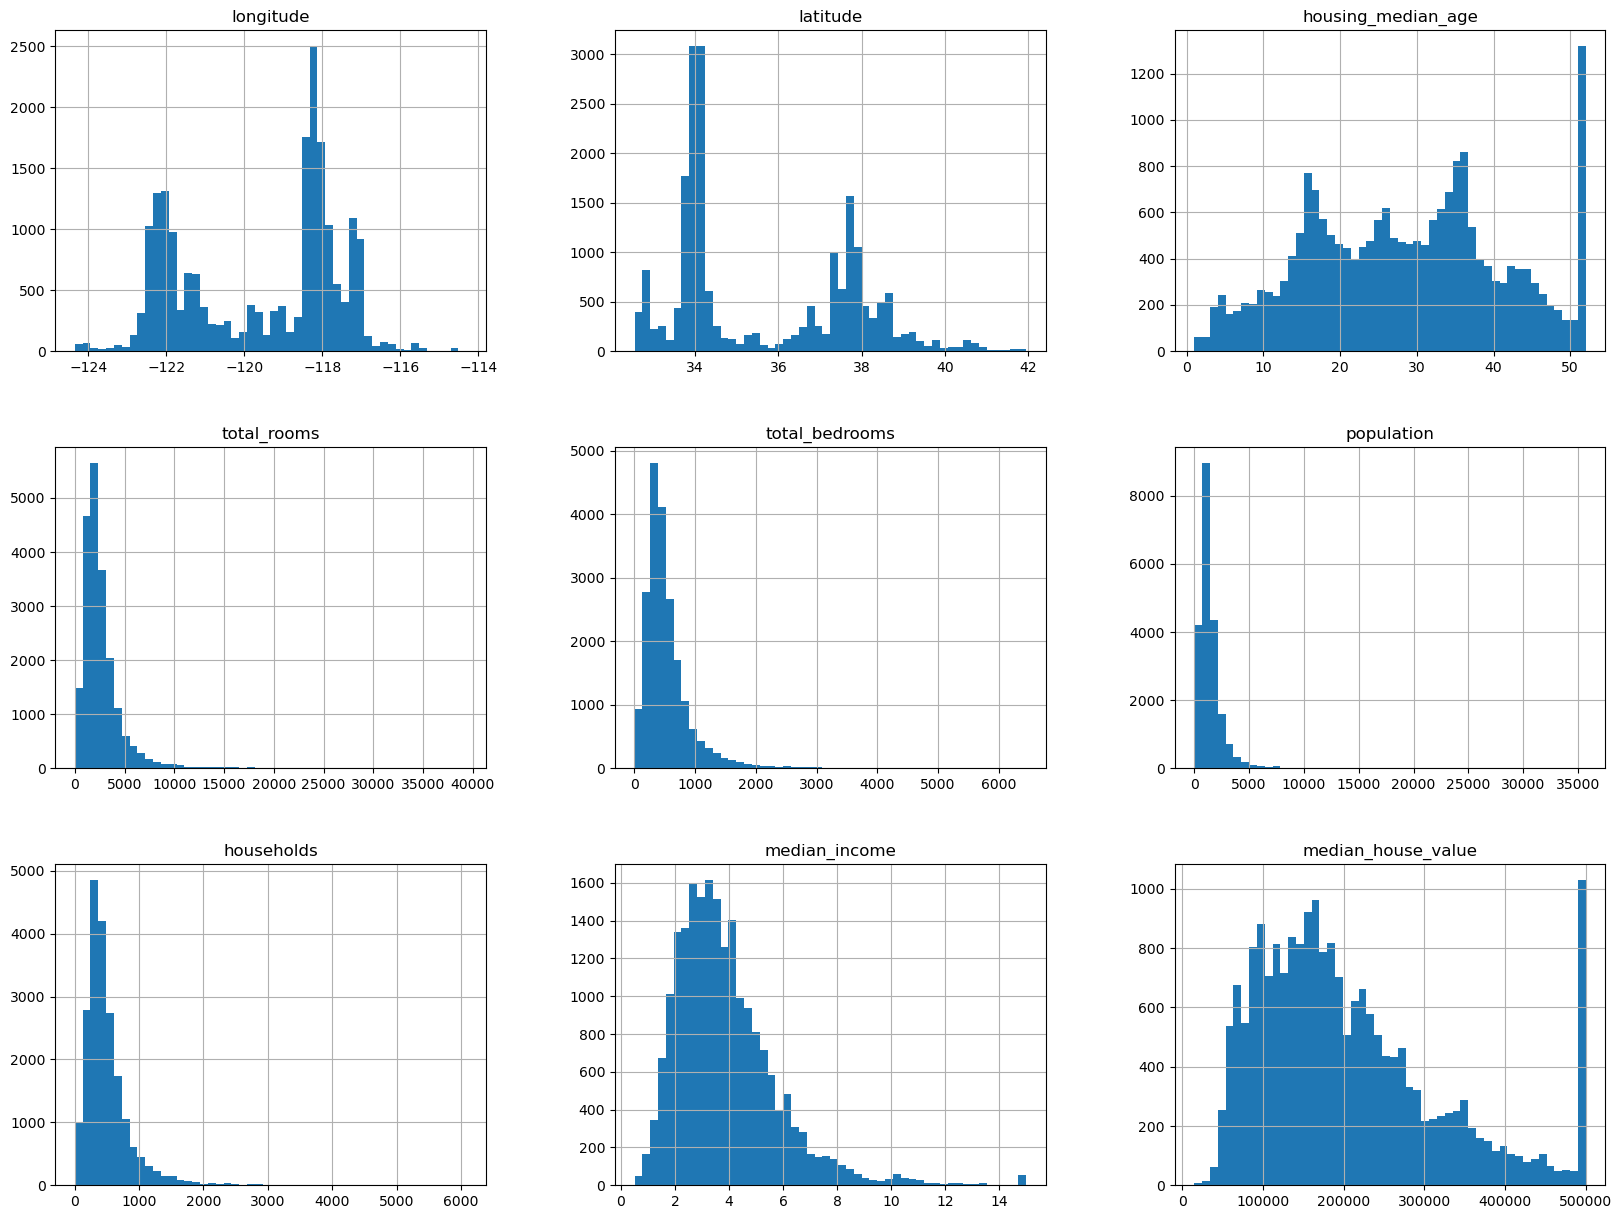

In [8]:
housing.hist(bins = 50, figsize=(20,15))
plt.show()

* Conclusiones:
 1. Median_income parece no estar expresado en USD. Después de hablar con el cliente, nos dice que ha sido escalado y capado. Escalado entre 1000 y capado entre 0,5 ( 5000 USD) Y 15 (150.000 USD).
 2. housing_median_age está capado en 500k, tenemos dos opciones: Recoger la media de edad correcta para esos datos o quitar esos distritos del training set.
 3. Las variables tiene diferentes escalas.
 4. Muchos histogramas son de cola larga, lo que puede dificultar los algoritmos de ML.

## SEPARAR EN TRAIN/TEST

In [9]:
from sklearn.model_selection import train_test_split
train_set,test_set = train_test_split(housing, test_size = 0.2, random_state= 42)

Creamos una categoria segun ingresos, diviendo 1.5 y redondeando con ceil

In [10]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [11]:
# Creamos una copia del train_set
housing = train_set.copy()

## VISUALIZANDO LOS DATOS

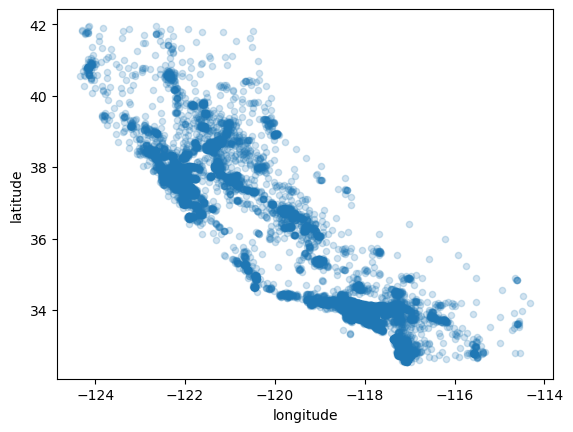

In [12]:
housing.plot(kind= 'scatter', x = 'longitude', y = 'latitude', alpha = 0.2);

Visualizamos el precio de las casas según leyenda de colores  y los habitantes según  radio de círculos.

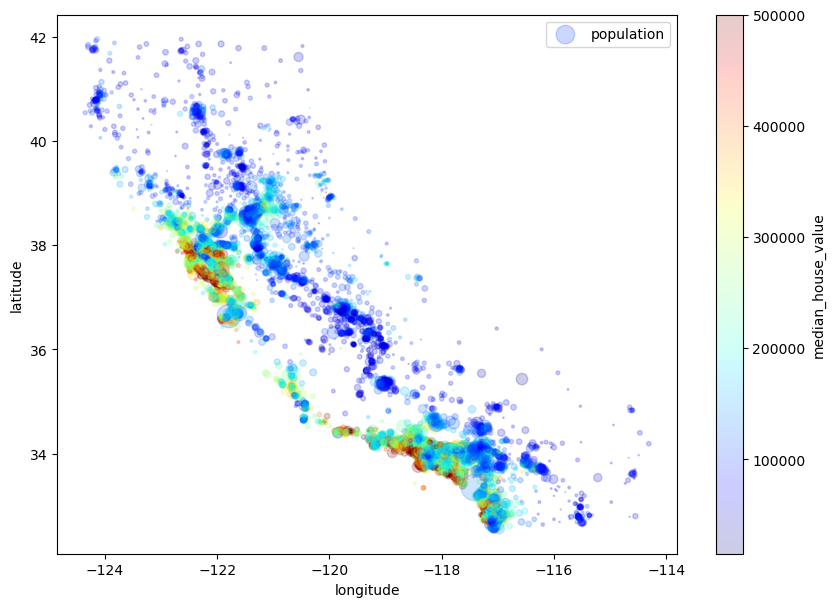

In [13]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2,
s=housing["population"]/100, label="population", figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend();

 -Conclusion: 
 * El precio de las viviendas está muy relacionado  a la localización y a los habitantes. 
 * Podría vere afectado por la proximidad del océano

## Busqueda de correlaciones

In [14]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

C:\Users\PEDRO\AppData\Local\Temp\ipykernel_12884\2724363209.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value    1.000000
median_income         0.690647
total_rooms           0.133989
housing_median_age    0.103706
households            0.063714
total_bedrooms        0.047980
population           -0.026032
longitude            -0.046349
latitude             -0.142983
Name: median_house_value, dtype: float64

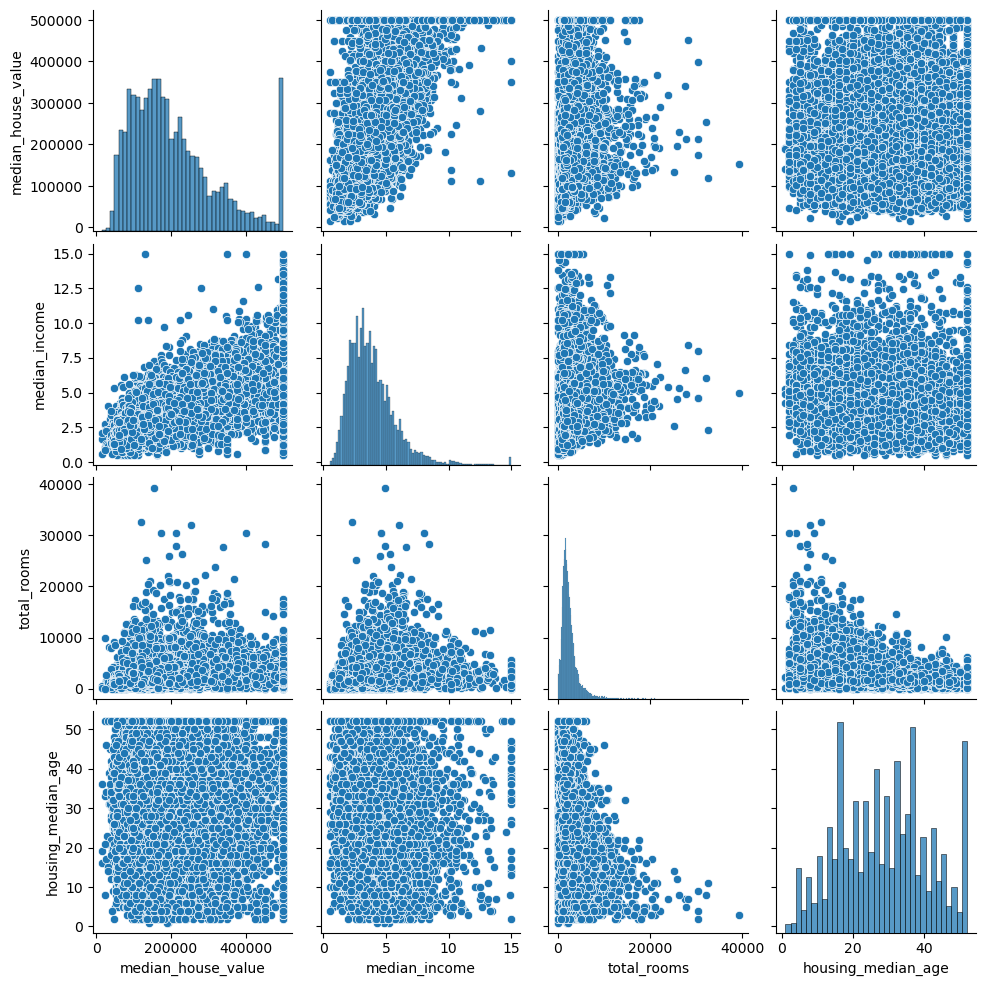

In [24]:

attributes = ['median_house_value','median_income','total_rooms','housing_median_age']

sns.pairplot(housing, x_vars= attributes, y_vars= attributes,kind='scatter');

Comprobamos gráficamente que median_income correlaciona fuerte con median_house_value ( nuestra variable target)

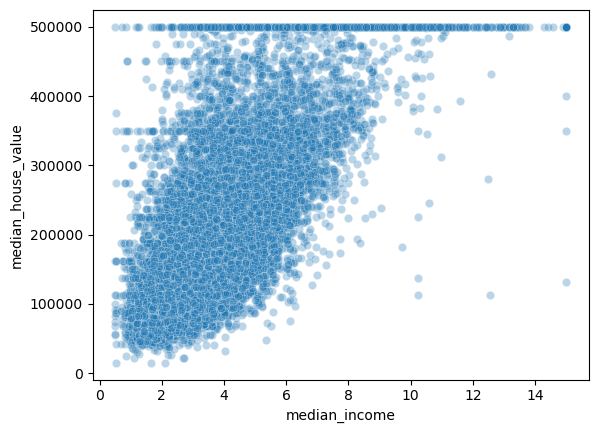

In [15]:
sns.scatterplot(data= housing, x = 'median_income', y= 'median_house_value', alpha= 0.3);

El gráfico revela que la correlacción es muy fuerte, por otra parte se observa que el gráfico está cortado por la línea horizontal de 500.000 , aunque existen otras líneas sobre los 450,000 , 350,000  y quizás sobre los 280,000 .

## Creacion de nuevas variables

 * Las variables: Total_rooms, total_bedrooms, population no aportar información, hay que transformarlas

In [15]:
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


In [16]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

 * Beedrooms_per_room, tiene mas correlacion que total_rooms. Las casas con menor ratio bedroom/room tienden a ser más caras.

## Preparacion de datos para algoritmos Machine Learning

In [17]:
housing= train_set.drop('median_house_value',axis =1)
housing_labels= train_set['median_house_value'].copy()

### Variables continuas

In [18]:
#Imputamos nulos por la mediana

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [19]:
housing_num= housing.drop('ocean_proximity',axis=1)          #Quitamos variable categorica para calcular mediana

In [20]:
imputer.fit(housing_num)                   #Entrenamos el imp 

SimpleImputer(strategy='median')

In [21]:
imputer.statistics_                     # El imp contiene la mediana de cada variable y lo almacena en statistics_

array([-118.51  ,   34.26  ,   29.    , 2129.    ,  437.    , 1167.    ,
        410.    ,    3.5458])

In [22]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2129.    ,  437.    , 1167.    ,
        410.    ,    3.5458])

In [23]:
X=imputer.transform(housing_num)      #Una vez el imputer esta entrenado, hacemos un transform al training set cambiando los valores vacios por la mediana aprendida.

In [24]:
housing_tr= pd.DataFrame(X,columns=housing_num.columns)         # Transformamos  a DataFrame
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596
1,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125
2,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563
3,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425
4,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542
...,...,...,...,...,...,...,...,...
16507,-117.96,33.78,35.0,1330.0,201.0,658.0,217.0,6.3700
16508,-117.43,34.02,33.0,3084.0,570.0,1753.0,449.0,3.0500
16509,-118.38,34.03,36.0,2101.0,569.0,1756.0,527.0,2.9344
16510,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192


### Variable categorica

Opcion 1, pasar LabelEncoder + OneHotEncoder

In [25]:
from sklearn.preprocessing import LabelEncoder        #A través de LabelEncoder, convertimos variable categórica a numérica
encoder = LabelEncoder()
housing_cat= housing['ocean_proximity']
housing_cat_encoded= encoder.fit_transform(housing_cat)
housing_cat_encoded

array([4, 4, 4, ..., 0, 0, 3])

In [26]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [27]:
from sklearn.preprocessing import OneHotEncoder        #Convierte valores categoricos entereos en one-hot-vectors con formato Scipy sparse Matrix.
encoder= OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [28]:
housing_cat_1hot.toarray()             #Convierte a  un denso array de NumPy

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Opcion 2: Pasar LabelBinarizer 

In [29]:
from sklearn.preprocessing import LabelBinarizer
encoder= LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

### Tranformaciones personalizadas

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)



class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

### Transformacion de pipelines

In [31]:
#Pipeline variables numéricas aplicando StandarScaler()

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [32]:
#La clase DataFrameSelector transformará los datos selecionando las variables deseados, 
#eliminando el resto y convirtiendo de DataFrame  a un NumPy Array, manejando solo datos numericos.


from sklearn.base import BaseEstimator, TransformerMixin
    
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [36]:
#Construimos otro pipeline para las variables categoricos, aplicando LabelBinarizer()

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', MyLabelBinarizer()),
])

In [37]:
# Union de Pipelines con FeautureUnion(), trabaja de forma paralela con ambos pipesline.

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
        ])


In [38]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared


array([[ 1.27258656, -1.3728112 ,  0.34849025, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.70916212, -0.87669601,  1.61811813, ...,  0.        ,
         0.        ,  1.        ],
       [-0.44760309, -0.46014647, -1.95271028, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.59946887, -0.75500738,  0.58654547, ...,  0.        ,
         0.        ,  0.        ],
       [-1.18553953,  0.90651045, -1.07984112, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41489815,  0.99543676,  1.85617335, ...,  0.        ,
         1.        ,  0.        ]])

In [39]:
housing_prepared.shape

(16512, 16)

## Training y Evaluation 

In [40]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)


LinearRegression()

In [43]:
some_data= housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print('Predictions:', lin_reg.predict(some_data_prepared))
print('Labels:', list(some_labels))

Predictions: [181746.54359616 290558.74973505 244957.50017771 146498.51061398
 163230.42393939]
Labels: [103000.0, 382100.0, 172600.0, 93400.0, 96500.0]


In [44]:
# Medimos el error del modelo con la métrica RMSE
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse= mean_squared_error(housing_labels,housing_predictions)
lin_rmse= np.sqrt(lin_mse)

lin_rmse

67593.20745775253

Vemos que la prediccion no es muy satisfactoria, la media del valor de casas oscila entre 120k y 265k, y tenemos un error tipico en la predeccion de 68k ..

Esto es un ejemplo de  de modelo under-fitting. Las soluciones principales para combatir el under-fitting son:
 
 * Elegir un modelo más potente/complejo ( DecisionTreeRegressor)
 * Alimentar el algoritmo con más variables
 * Reducir limitaciones del modelo( Hiperparámetros)

In [47]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [49]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse= mean_squared_error(housing_labels,housing_predictions)
tree_rmse= np.sqrt(lin_mse)
tree_rmse


0.0

El modelo ha sobreajustado, no es perfecto.  Tenemos que dividir los datos en training_set y validatio_set.

Utilizamos validacion_cruzada.

In [51]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
            scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)


In [53]:
 def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)
     

Scores: [64755.72230018 69696.79051894 68068.93893079 70567.94007455
 73352.18954473 65881.70047672 68201.07323899 67995.18283551
 66275.10654984 69074.44779028]
Mean: 68386.9092260527
Standard deviation: 2362.409619083551


* Podemos comprobar que el algoritmo no es tan bueno. Aplicaremos ahora validacion cruzada a la regresion lineal:

In [55]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
 scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [65000.67382615 70960.56056304 67122.63935124 66089.63153865
 68402.54686442 65266.34735288 65218.78174481 68525.46981754
 72739.87555996 68957.34111906]
Mean: 67828.38677377408
Standard deviation: 2468.0913950652302


* Como vemos el arból de decision esta sobre-ajustado y funciona peor que el modelo lineal.
* Porbaremos un último modelo: RandomForestRegressor

In [61]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
 
forest_scores = cross_val_score(forest_reg,housing_prepared,housing_labels,
scoring='neg_mean_squared_error',cv = 5)

forest_rmse_scores= np.sqrt(-forest_scores)
forest_rmse
display_scores(forest_rmse_scores)

Scores: [49911.68750916 51379.07674645 50321.28771043 49750.61834517
 50337.35906919]
Mean: 50340.00587608147
Standard deviation: 567.6019615895568


*   Aclarar que el resultado del training set es mas bajo que los de validation set, significa que el modelo sigue sobre-ajustando el training_Set

Guardarmos los 3 modelos utilizamos en formato Pickle

In [65]:
from joblib import dump

dump(forest_reg, 'RandomForestRegressor.pkl')


['RandomForestRegressor.pkl']

In [66]:
from joblib import dump

dump(tree_reg, 'tree_reg.pkl')


['tree_reg.pkl']

In [67]:
from joblib import dump

dump(lin_reg, 'lin_reg.pkl')


['lin_reg.pkl']